In [1]:
import math
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 -  4*x + 5

In [3]:
f(3.0)

20.0

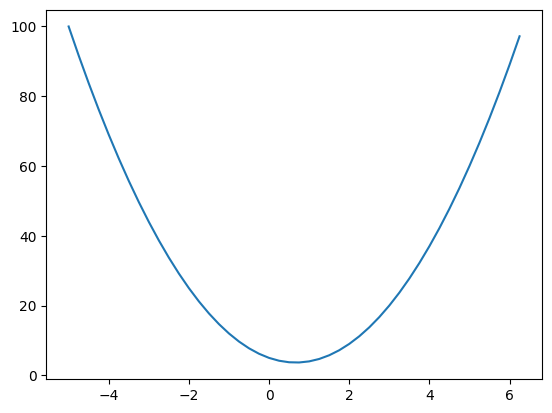

In [4]:
xs=np.arange(-5, 6.26, 0.25)
ys=f(xs)    
plt.plot(xs, ys)

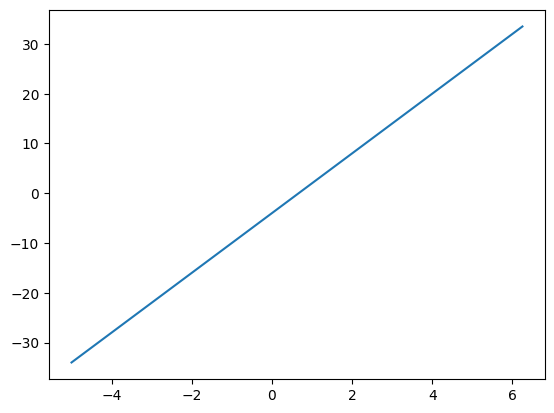

In [5]:
def derf(x):     # derivative of f(x)
    return 6*x - 4

xs=np.arange(-5, 6.26, 0.25)
ys=derf(xs)
plt.plot(xs, ys)

In [6]:
h = 0.0000001
x = -3.0
derivative = (f(x+h) - f(x))/h
print(derivative)

-21.999999688659955


In [7]:
# lets get more complex

a=2.0
b=-3.0
c=10.0  
d=a*b + c
print(d)

4.0


In [8]:
h = 0.0001

# Inputs
a=2.0
b=-3.0
c=10.0  


d1=a*b + c
a+=h
d2=a*b + c

print('d1 -->', d1) 
print('d2 -->', d2)
print('slope -->', (d2-d1)/h)

d1 --> 4.0
d2 --> 3.999699999999999
slope --> -3.000000000010772


d2 decreased => slope is negative

In [9]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad=0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1*out.grad
            other.grad += 1*out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other*self.data**(other-1))*out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other*Value(2.0)
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += math.exp(x)*out.grad
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set() 
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1
        for node in reversed(topo):
            node._backward()
    
    
a=Value(2.0, label='a')
b=Value(-3.0, label='b')
c=Value(10.0, label='c')
e=a+b; e.label='e'
d=e+c; d.label='d'
f=Value(3.0, label='f')
L=d*f; L.label='L'
L

Value(data=27.0)

In [10]:
a + 3.4

Value(data=5.4)

In [11]:
from graphviz import Digraph # type: ignore

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

In [12]:
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})   # Left to Right
    nodes, edges = trace(root)
    for n in nodes:
        uid= str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

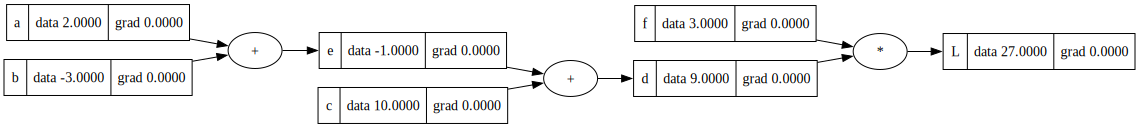

In [13]:
draw_dot(L)

In [14]:
d.grad= 6.0
f.grad=12.0

In [15]:
def lol():
    h=0.001
    a=Value(2.0, label='a')
    b=Value(-3.0, label='b')
    c=Value(10.0, label='c')
    e=a+b; e.label='e'
    d=e+c; d.label='d'
    f=Value(3.0, label='f')
    L=d*f; L.label='L'
    L1=L.data

    a=Value(2.0 + h, label='a')
    b=Value(-3.0, label='b')
    c=Value(10.0, label='c')
    e=a+b; e.label='e'
    d=e+c; d.label='d'
    d.data+=h
    f=Value(3.0, label='f')
    L=d*f; L.label='L'
    L2=L.data
    print('slope -->', (L2-L1)/h)

lol()

slope --> 5.999999999996675


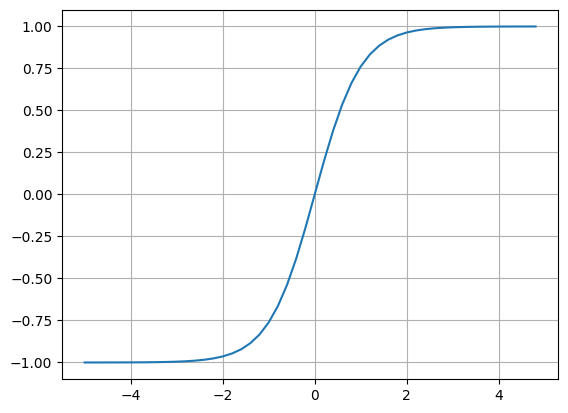

In [16]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

In [17]:
# inputs x1, x2

x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')

# weights w1, w2
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')

# bias
b=Value(6.8813735870195432, label='b')


# n = x1*w1 + x2*w2 + b
x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2+b; n.label='n'
o=n.tanh(); o.label='o'

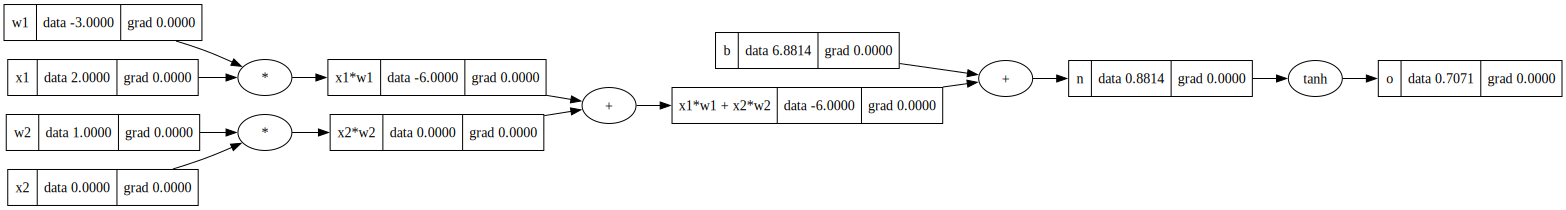

In [18]:
draw_dot(o)

In [19]:
o.backward()

In [20]:
o.grad=1.0

topo = []
visited = set() 
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

In [21]:
topo = []
visited = set() 
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [22]:
o.grad=1.0
o._backward()

In [23]:
n._backward()

In [24]:
b._backward()

In [25]:
x1w1x2w2._backward()

In [26]:
x2w2._backward()
x1w1._backward()

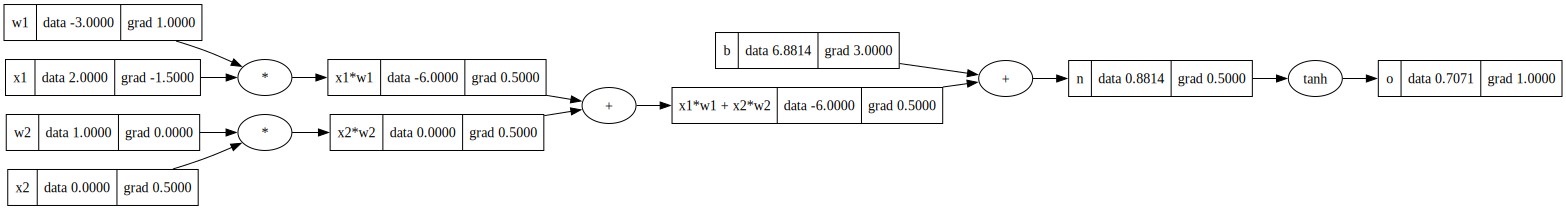

In [27]:
o.grad=1.0
n.grad=0.5
x1w1x2w2.grad=0.5
x1w1.grad=0.5
x2w2.grad=0.5
x2.grad=w2.data * x2w2.grad
w2.grad=x2.data * x2w2.grad
x1.grad=w1.data * x1w1.grad
w1.grad=x1.data * x1w1.grad
draw_dot(o)

In [28]:
# O = tanh(n)   
# dO/dn = 1 - O^2

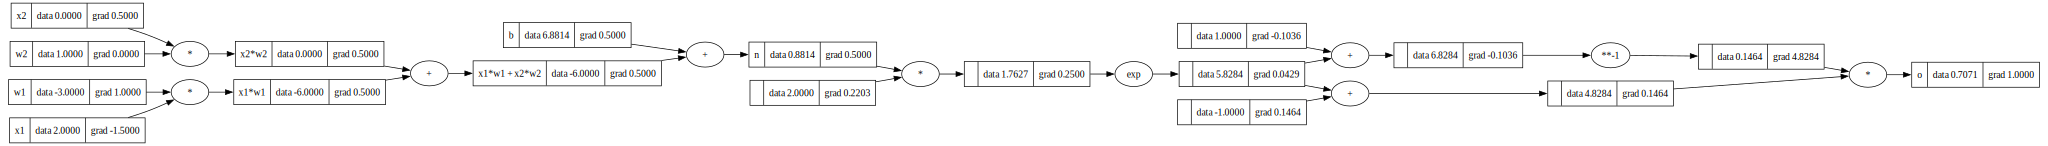

In [29]:
# inputs x1, x2

x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')

# weights w1, w2
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')

# bias
b=Value(6.8813735870195432, label='b')


# n = x1*w1 + x2*w2 + b
x1w1=x1*w1; x1w1.label='x1*w1'
x2w2=x2*w2; x2w2.label='x2*w2'
x1w1x2w2=x1w1+x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2+b; n.label='n'
#--------------------------
e = (2*n).exp()
o = (e -1)/(e + 1); o.label='o'
o.backward()
draw_dot(o)

## Micrograd using Pytorch

In [30]:
import torch

In [31]:
x1 = torch.Tensor([2.0]).double()                  ; x1.requires_grad=True
x2 = torch.Tensor([0.0]).double()                  ; x2.requires_grad=True
w1 = torch.Tensor([-3.0]).double()                 ; w1.requires_grad=True
w2 = torch.Tensor([1.0]).double()                  ; w2.requires_grad=True
b = torch.Tensor([6.8813735870195432]).double()    ; b.requires_grad=True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [53]:
import random
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w *x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]    
    
class Layer:
    def __init__(self, n, m):
        self.neurons = [Neuron(n) for _ in range(m)]
    
    def __call__(self, x):
        outs =  [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x
    
    def parameters(self):
        return [p for l in self.layers for p in l.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.8518177951223442)

In [55]:
len(n.parameters())

41

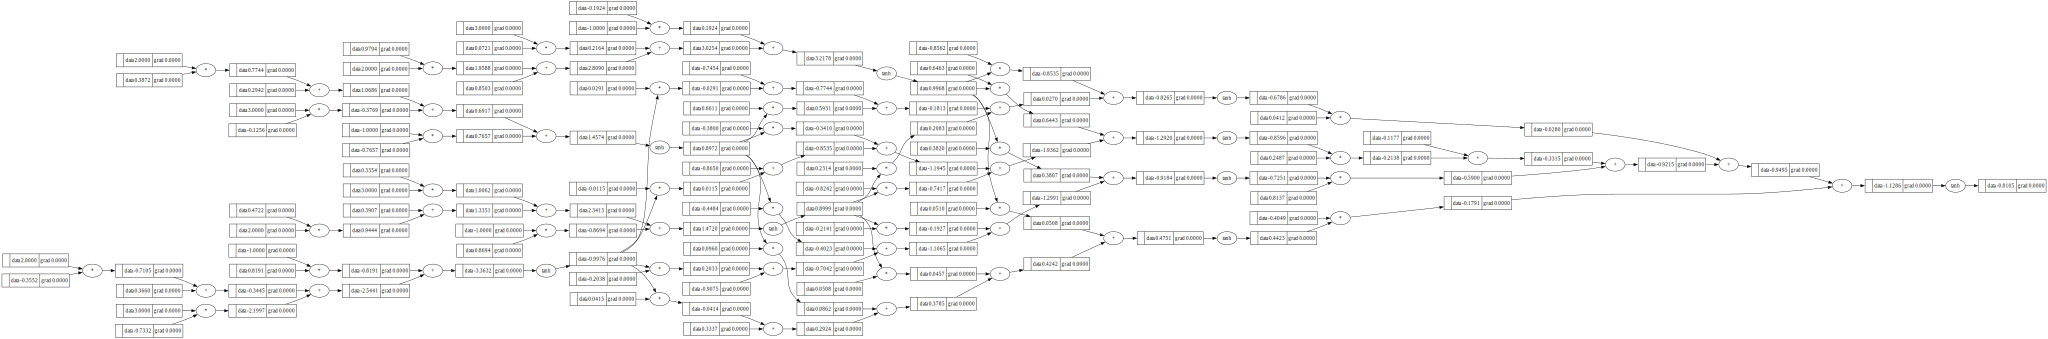

In [33]:
draw_dot(n(x))

In [56]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0]  # desired targets
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.8518177951223442),
 Value(data=-0.5916505913787506),
 Value(data=-0.1616814831372401),
 Value(data=-0.6396705664649125)]

In [57]:
[(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]   # mse

[Value(data=3.4292291463317803),
 Value(data=0.1667492395213241),
 Value(data=0.7027779357149775),
 Value(data=2.688519566531367)]

In [58]:
# Fix loss calculation by ensuring all values are Value objects
def calculate_loss(ypred, ys):
    # Convert ground truth values to Value objects if they aren't already
    ys = [Value(y) if not isinstance(y, Value) else y for y in ys]
    # Calculate MSE loss
    losses = [(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]
    return sum(losses, Value(0.0))

# Use the fixed loss calculation
loss = calculate_loss(ypred, ys)
loss

Value(data=6.9872758880994486)

In [59]:
loss.backward()

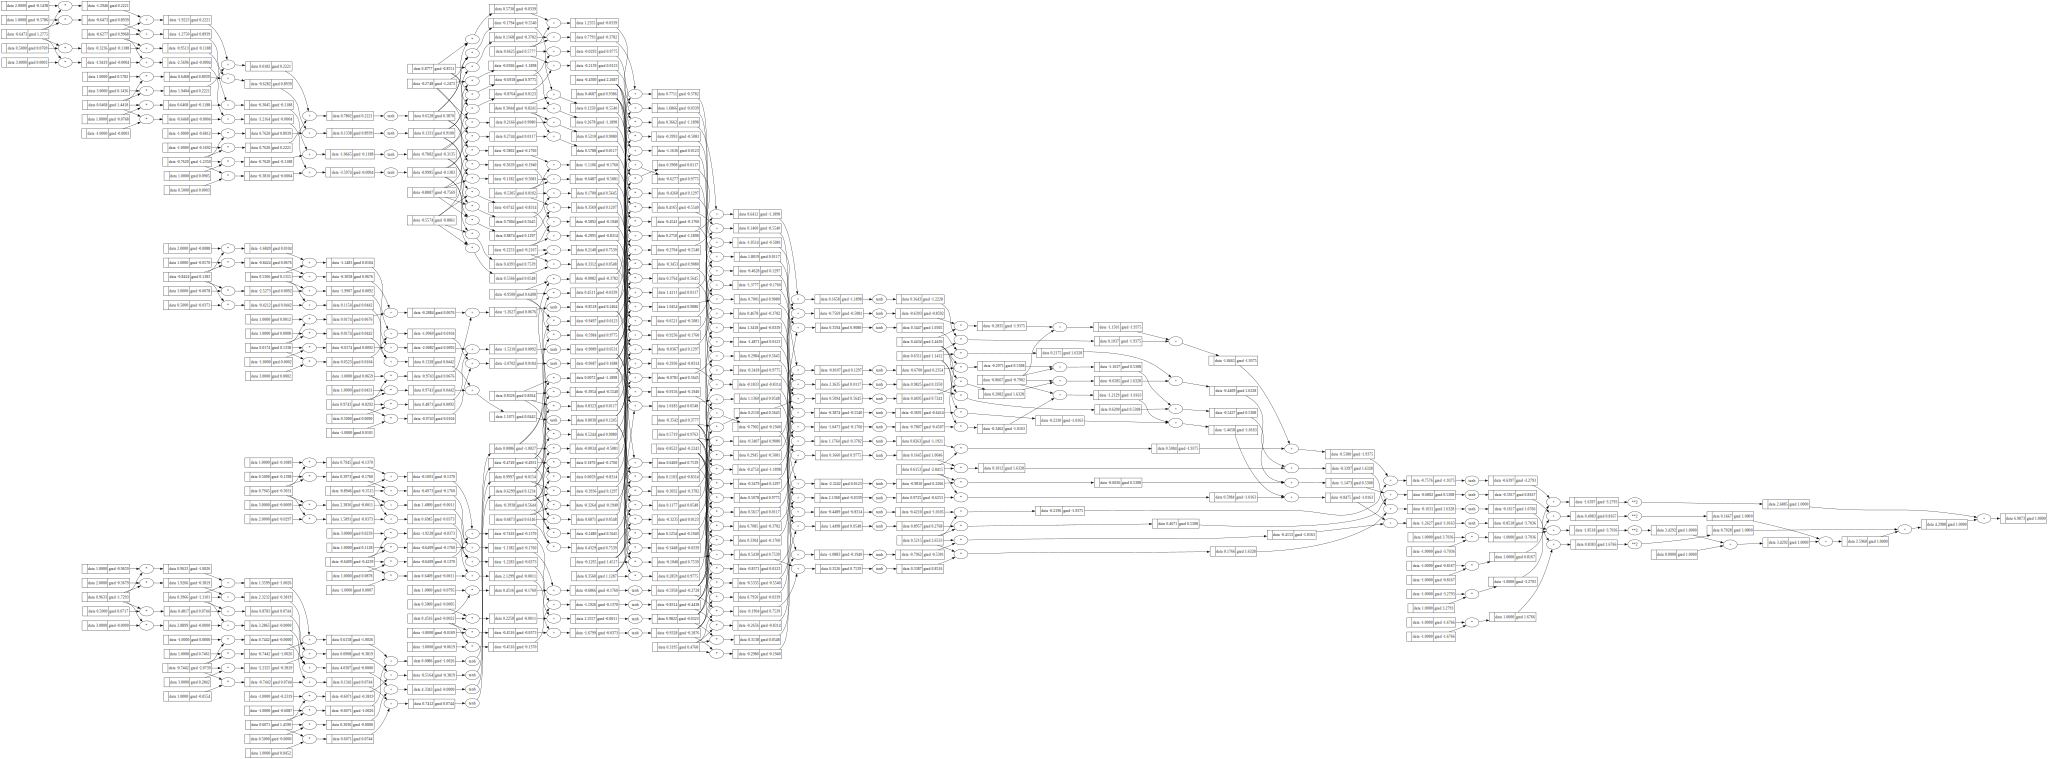

In [62]:
draw_dot(loss)

In [60]:
n.layers[0].neurons[0].w[0].grad

1.2774612834568007

In [61]:
n.layers[0].neurons[0].w[0].data

-0.6472956190798376

In [ ]:
for p in n.parameters():
    p.data -= 0.01*p.grad